# PMSM MPC dq current control

In [1]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git gekko

In [2]:
import numpy as np
import math
import gym_electric_motor as gem
from gekko import GEKKO
from gym_electric_motor.physical_systems import ConstantSpeedLoad
from gym_electric_motor.physical_systems import PhysicalSystem
from gym_electric_motor import reference_generators as rg
from gym_electric_motor.reference_generators import MultipleReferenceGenerator, SwitchedReferenceGenerator, \
        TriangularReferenceGenerator, WienerProcessReferenceGenerator, StepReferenceGenerator, \
        SinusoidalReferenceGenerator, ConstReferenceGenerator 
from gym_electric_motor.visualization.motor_dashboard import MotorDashboard

/home/wilhelmk/tools/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Definition of a general controller class

In [3]:
class Controller:

    @classmethod
    def make(cls, controller_type, environment, **controller_kwargs):
        assert controller_type in _controllers.keys(), f'Controller {controller_type} unknown'
        controller = _controllers[controller_type](environment, **controller_kwargs)
        return controller

    def control(self, state, reference):
        raise NotImplementedError

    def reset(self):
        pass

Defenition of the MPC class

In [4]:
class MPC(Controller):
    def __init__(self, environment, ph=5, ref_idx_q=0, ref_idx_d=1):
        # conversion of the coordinate systems
        t32 = environment.physical_system.electrical_motor.t_32
        q = environment.physical_system.electrical_motor.q
        self._backward_transformation = (lambda quantities, eps: t32(q(quantities[::-1], eps)))
    
        # indices
        self.ref_idx_i_q = ref_idx_q
        self.ref_idx_i_d = ref_idx_d
        self.current_idx = environment.physical_system.CURRENTS_IDX
        self.voltage_idx = environment.physical_system.VOLTAGES_IDX
        self.i_sq_idx = self.current_idx[3]
        self.i_sd_idx = self.current_idx[4]
        self.u_a_idx = self.voltage_idx[0]
        self.u_b_idx = self.voltage_idx[1]
        self.u_c_idx = self.voltage_idx[2]
        self.u_sq_idx = self.voltage_idx[3]
        self.u_sd_idx = self.voltage_idx[4]
        self.omega_idx = environment.physical_system.OMEGA_IDX
        self.epsilon_idx = environment.physical_system.EPSILON_IDX

        # motor parameters
        self.tau = environment.physical_system.tau
        self.limits = environment.physical_system.limits
        self.l_q = environment.physical_system.electrical_motor.motor_parameter['l_q']
        self.l_d = environment.physical_system.electrical_motor.motor_parameter['l_d']
        self.psi_ = environment.physical_system.electrical_motor.motor_parameter['psi_p']
        self.r_s = environment.physical_system.electrical_motor.motor_parameter['r_s']
        self.p = environment.physical_system.electrical_motor.motor_parameter['p']
        self.ph_ = ph


    def control(self, state, reference):
        # initialize variables
        epsilon_el = state[self.epsilon_idx] * self.limits[self.epsilon_idx]
        omega = self.p * state[self.omega_idx] * self.limits[self.omega_idx]

        ref_q = []
        ref_d = []
        eps = []
        lim_a_up = []
        lim_a_low = []
        
        for i in range(self.ph_):
            ref_q.append(reference[self.ref_idx_i_q] * self.limits[self.i_sq_idx])
            ref_d.append(reference[self.ref_idx_i_d] * self.limits[self.i_sd_idx])
         
            eps.append(epsilon_el + (i-1) * self.tau * omega)
            lim_a_up.append(2 * self.limits[self.u_a_idx])
            lim_a_low.append(-2 * self.limits[self.u_a_idx])
        
        m = GEKKO(remote=False)
        
        # defenition of the prediction Horizon
        m.time = np.linspace(self.tau, self.tau * self.ph_, self.ph_)

        # defenition of the variables
        u_d = m.MV(value=state[self.u_sd_idx] * self.limits[self.u_sd_idx])
        u_q = m.MV(value=state[self.u_sq_idx] * self.limits[self.u_sq_idx])
        u_d.STATUS = 1
        u_q.STATUS = 1

        u_a_lim_up = m.Param(value=lim_a_up)
        u_a_lim_low = m.Param(value=lim_a_low)
        sq3 = math.sqrt(3)

        i_d = m.SV(value=state[self.i_sd_idx] * self.limits[self.i_sd_idx], lb=-self.limits[self.i_sd_idx], ub=self.limits[self.i_sd_idx] )
        i_q = m.SV(value=state[self.i_sq_idx] * self.limits[self.i_sq_idx], lb=-self.limits[self.i_sq_idx], ub=self.limits[self.i_sq_idx])

        epsilon = m.Param(value=eps)
        
        # reference trajectory
        traj_d = m.Param(value=ref_d)
        traj_q = m.Param(value=ref_q)
        
        # defenition of the constants
        omega = m.Const(value=omega)
        psi = m.Const(value=self.psi_)
        rs = m.Const(value=self.r_s)
        ld = m.Const(value=self.l_d)
        lq = m.Const(value=self.l_q)
        
        # control error
        e_d = m.CV()
        e_q = m.CV()
        e_d.STATUS = 1
        e_q.STATUS = 1
        
        # solver options
        m.options.CV_TYPE = 2
        m.options.IMODE = 6
        m.options.solver = 3
        m.options.WEB = 0
        m.options.NODES = 2
        
        # differential equations
        m.Equations([ld * i_d.dt() == u_d - rs * i_d + omega * lq * i_q,
                     lq * i_q.dt() == u_q - rs * i_q - omega * ld * i_d - omega * psi])
        
        # cost function
        m.Equations([e_d == (i_d - traj_d), e_q == (i_q - traj_q)])
        
        # voltage limitations
        m.Equation(u_a_lim_up >= 3/2 * m.cos(epsilon) * u_d - 3/2 * m.sin(epsilon) * u_q - sq3/2 * m.sin(epsilon) * u_d - sq3/2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= 3 / 2 * m.cos(epsilon) * u_d - 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_up >= sq3 * m.sin(epsilon) * u_d + sq3 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= sq3 * m.sin(epsilon) * u_d + sq3 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_up >= -3 / 2 * m.cos(epsilon) * u_d + 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= -3 / 2 * m.cos(epsilon) * u_d + 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        
        # object to minimize
        m.Obj(e_d)
        m.Obj(e_q)
        
        # solving optimization problem
        m.solve(disp=False)
        
        # additional voltage limitation
        u_a, u_b, u_c = self._backward_transformation((u_q.NEWVAL, u_d.NEWVAL), epsilon_el)
        u_max = max(np.absolute(u_a - u_b), np.absolute(u_b - u_c), np.absolute(u_c - u_a))
        if u_max >= 2 * self.limits[self.u_a_idx]:
            u_a = u_a / u_max * 2 * self.limits[self.u_a_idx]
            u_b = u_b / u_max * 2 * self.limits[self.u_a_idx]
            u_c = u_c / u_max * 2 * self.limits[self.u_a_idx]
        
        # Zero Point Shift
        u_0 = 0.5 * (max(u_a, u_b, u_c) + min(u_a, u_b, u_c))
        u_a -= u_0
        u_b -= u_0
        u_c -= u_0
        
        # normalization of the manipulated variables
        u_a /= self.limits[self.u_a_idx]
        u_b /= self.limits[self.u_b_idx]
        u_c /= self.limits[self.u_c_idx]
        
        return u_a, u_b, u_c

    def reset(self):
        pass


_controllers = {
    'mpc': MPC
}

Setting parameters of the motor

In [5]:
motor_parameter = dict(r_s=15e-3, l_d=0.37e-3, l_q=1.2e-3, psi_p=65.6e-3, p=3, j_rotor=0.06)
limit_values = dict(i=160 * 1.41, omega=12000 * np.pi / 30, u=450)
nominal_values = {key: 0.7 * limit for key, limit in limit_values.items()}

q_generator = SwitchedReferenceGenerator(
        sub_generators=[
            TriangularReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 1), offset_range=(0, 0.8)),
            WienerProcessReferenceGenerator(reference_state='i_sq'),
            StepReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 1), offset_range=(0, 1)),
            SinusoidalReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 1), offset_range=(0, 0.8))],
        p=[0.3, 0.2, 0.3, 0.2], super_episode_length=(1000, 10000)
    )

d_generator = SwitchedReferenceGenerator(
        sub_generators=[
            TriangularReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.6), offset_range=(0, 0.5)),
            WienerProcessReferenceGenerator(reference_state='i_sd'),
            StepReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.8), offset_range=(0, 0.6)),
            SinusoidalReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.6), offset_range=(0, 0.5)),
            ConstReferenceGenerator(reference_state='i_sd', value=0)],
        p=[0.25, 0.1, 0.25, 0.2, 0.2], super_episode_length=(1000, 10000)
    )

reference_generator = MultipleReferenceGenerator([q_generator, d_generator])

Initialization of the pmsm and the controller

In [6]:
env = gem.make('emotor-pmsm-cont-v1',
            visualization=MotorDashboard(plots=['i_sq', 'i_sd', 'reward']),#, visu_period=1,
            load=ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30),
            ode_solver='scipy.solve_ivp', solver_kwargs={},
            reference_generator=reference_generator,
            plotted_variables=['i_sq', 'i_sd', 'u_sq', 'u_sd'],
            reward_function='WSE',
            reward_weights={'i_sq': 1, 'i_sd': 1},
            reward_power=0.5,
            observed_states=['i_sq', 'i_sd'],
            dead_time=False,
            u_sup=400,
            motor_parameter=motor_parameter,
            limit_values=limit_values,
            nominal_values=nominal_values       
    )

controller = Controller.make('mpc', env, ph=3)

Running the control

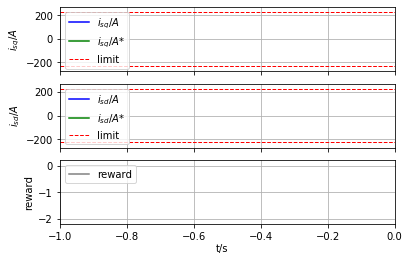

Exception: @error: Solution Not Found


In [7]:
state, reference = env.reset()
cum_rew = 0
    
for i in range(int(1e4)):
    env.render()
    action = controller.control(state, reference)
    (state, reference), reward, done, _ = env.step(action)
    cum_rew += reward
    if done:
        env.reset()
        
print('Reward =', cum_rew)
env.close()